In [6]:
from functools import partial

import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from NEExT.collections import EgonetCollection
from NEExT.experiment_utils.data_loading import load_abcdo_data, load_pygod_data
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.io import GraphIO
from NEExT.outliers import CosineOutlierDetector, OutlierDataset, LGBMOutlier

%reload_ext autoreload
%autoreload 2

In [7]:
graph_io = GraphIO()
hide_frac = {0: 0.8, 1: 0.8}

edges_df, mapping_df, features_df, ground_truth_df = load_pygod_data(hide_frac=hide_frac)
# edges_df, mapping_df, features_df, ground_truth_df = load_abcdo_data(hide_frac=hide_frac)

graph_data = {
    "target": "is_outlier",
    "skip_features": [],
    "feature_list": [],
    # "feature_list": [i for i in features_df.columns[1:-1]],
}

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


In [8]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=5, feature_list=graph_data["feature_list"])

In [9]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy="structural_embedding",
    structural_embedding_dimension=5,
    feature_embedding_dimension=5,
    embedding_algorithm="approx_wasserstein",
    # approx_wasserstein, wasserstein, sinkhornvectorizer
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

In [18]:
import numpy as np
def objective(trial: optuna.Trial, model: str):
    if model == "cosine":
        top_k = trial.suggest_int("top_k", 1, 20)
        detector = CosineOutlierDetector(top_k=top_k)
    elif model == "knn":
        n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
        detector = KNeighborsClassifier(n_neighbors=n_neighbors)
    elif model == "lgbm":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 1, 75),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 10, 100),
            "max_depth": trial.suggest_int("max_depth", 1, 100),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_alpha": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "reg_lambda": trial.suggest_float("learning_rate", 1e-5, 1e1, log=True),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1),
        }

        detector = LGBMOutlier(**params)

    metric = cross_val_score(
        detector,
        dataset.X_labeled,
        dataset.y_labeled,
        cv=StratifiedKFold(min(5, int(np.sum(dataset.y_labeled)))),
        n_jobs=-1,
        scoring=make_scorer(roc_auc_score),
    )
    return np.nanmean(metric)

model = "cosine"
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, model=model), n_trials=50, n_jobs=4)

if model == "cosine":
    detector = CosineOutlierDetector(**study.best_params)
elif model == "knn":
    detector = KNeighborsClassifier(**study.best_params)
elif model == "lgbm":
    detector = LGBMOutlier(**study.best_params)

detector.fit(dataset.X_labeled, dataset.y_labeled)
out_df, score = score_unlabeled_gt(dataset, detector, ground_truth_df)
score

[I 2025-03-30 20:26:53,562] A new study created in memory with name: no-name-4b228abe-f5a5-497a-ab73-bd6f6a03ae46
[I 2025-03-30 20:26:53,714] Trial 3 finished with value: 0.5 and parameters: {'top_k': 12}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,758] Trial 1 finished with value: 0.5 and parameters: {'top_k': 3}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,776] Trial 0 finished with value: 0.5 and parameters: {'top_k': 16}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,791] Trial 2 finished with value: 0.5 and parameters: {'top_k': 12}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,866] Trial 4 finished with value: 0.5 and parameters: {'top_k': 11}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,911] Trial 5 finished with value: 0.5 and parameters: {'top_k': 18}. Best is trial 3 with value: 0.5.
[I 2025-03-30 20:26:53,946] Trial 6 finished with value: 0.5 and parameters: {'top_k': 9}. Best is trial 3 with value: 0.5.
[I 2025-03-30

0.5

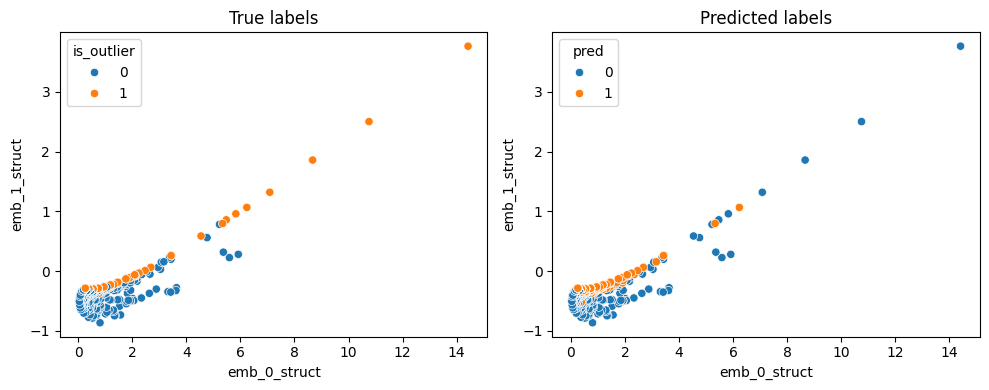

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df["is_outlier"], ax=ax[0])
ax[0].set_title("True labels")

sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=out_df["pred"], ax=ax[1])
ax[1].set_title("Predicted labels")

fig.tight_layout()